# Imports:

In [148]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

# new imports:
import rescomp.lyapunov_analysis as la

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lorenz iterator:

In [149]:
# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

dt = 0.05
def f_L(x):
    return data_creation_function(2, dt, x)[-1]

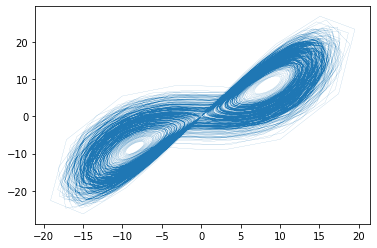

In [150]:
# test lorenz iterator:
time_steps = 10000
results = np.zeros((time_steps, 3))
results[0, :] = np.array([0, 1, 0])
for i in range(1, time_steps):
    x_last = results[i - 1, :]
    results[i, :] = f_L(x_last)

plt.plot(results[:, 0], results[:, 1], linewidth=0.1)

# Lorenz 96 Iterator:

### Plotting the pure Lorenz 96 system

In [151]:
lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta

dt = 0.05

In [152]:
# No coupling between Lorenz input and Lorenz96:
f_L96 = lambda x: iterator(lorenz_96, dt, x)

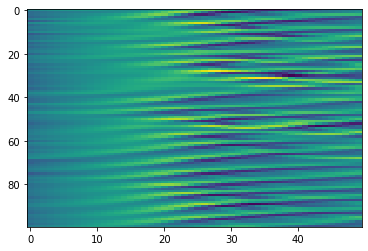

In [153]:
dims = 100

time_steps = 50
results_L96 = np.zeros((time_steps, dims))

# default starting points:
np.random.seed(1)
starting_point = np.random.randn(dims)
results_L96[0, :] = starting_point
for i in range(1, time_steps):
    x_last = results_L96[i - 1, :]
    results_L96[i, :] = f_L96(x_last)

plt.imshow(results_L96.T, aspect="auto")
# plt.xlim(0, 100)


## Iterator based coupling:

In [199]:
# test iterator:
dims = 200
time_steps = 10000

w_in_scale = 1
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))


# L96
results_L96 = np.zeros((time_steps, dims))
np.random.seed(1)
starting_point = np.random.randn(dims)
results_L96[0, :] = starting_point

results_L96_coupled = results_L96.copy()

# lorenz:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = np.array([0, 1, 0])

for i in range(1, time_steps):
    # baseline iteration:
    results_L96[i, :] = f_L96(results_L96[i - 1, :])

    x_last = results_L96_coupled[i - 1, :]
    x_last_in = results_L[i - 1, :]

    x_add = w_in.dot(np.tanh(x_last_in))
    # x_add = w_in.dot(x_last_in)

    inp = x_last + x_add
    # inp = np.tanh(x_last + x_add)
    results_L96_coupled[i, :] = f_L96(inp)
    results_L[i, :] = f_L(x_last_in)

# plt.imshow(results_L96.T, aspect="auto")

Text(0.5, 1.0, 'L96 coupled - L96')

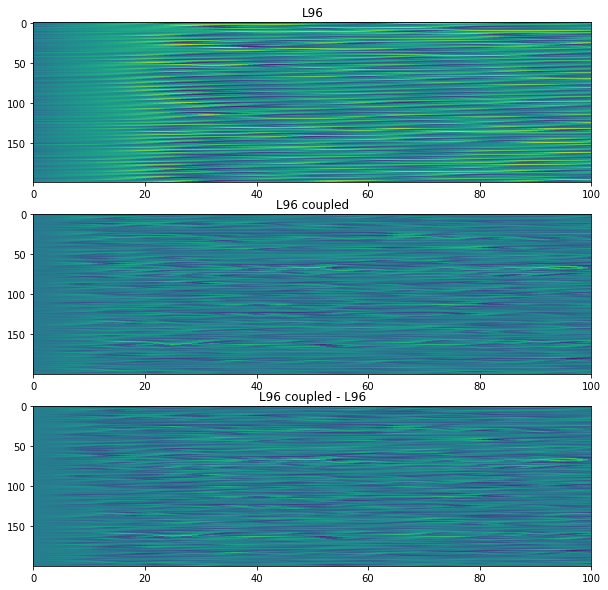

In [200]:
xlim = (0, 100)
# xlim = None

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

ax = axs[0]
ax.imshow(results_L96.T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96")

ax = axs[1]
ax.imshow(results_L96_coupled.T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96 coupled")

ax = axs[2]
ax.imshow((results_L96_coupled - results_L96).T, aspect="auto")
ax.set_xlim(xlim)
ax.set_title("L96 coupled - L96")

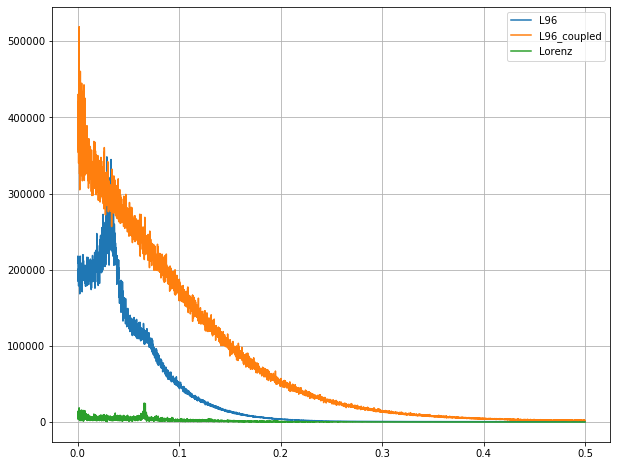

In [201]:
# Explore frequencies:
plt.figure(figsize=(10, 8))

x, y = rescomp.measures.fourier_spectrum(results_L96)
plt.plot(x, y, label="L96")

x, y = rescomp.measures.fourier_spectrum(results_L96_coupled)
plt.plot(x, y, label="L96_coupled")

x, y = rescomp.measures.fourier_spectrum(results_L)
plt.plot(x, y, label="Lorenz")

plt.grid()
plt.legend()

In [202]:
# Try to fit the coupled to the output:
sync_steps = 100
train_steps = 3000
test_steps = 1000

x_sync = results_L96_coupled[: sync_steps, :]
y_sync = results_L[: sync_steps, :]

x_train = results_L96_coupled[sync_steps: sync_steps + train_steps, :]
y_train = results_L[sync_steps: sync_steps + train_steps, :]

x_test = results_L96_coupled[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
y_test = results_L[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

x_test.shape

(1000, 200)

In [203]:
# Train:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.01)
model.fit(x_train, y_train)

Ridge(alpha=0.01)

In [204]:
y_test_pred = model.predict(x_test)
y_test_pred

array([[-4.0357832 , -3.52098166, 19.08770095],
       [-5.20603765, -4.19593787, 18.82534184],
       [-6.56109311, -5.59716693, 18.71896   ],
       ...,
       [ 7.45972699,  5.59085485, 15.09465178],
       [ 8.05374334,  7.37903933, 18.08950813],
       [ 7.0703752 ,  6.38312575, 19.97721714]])

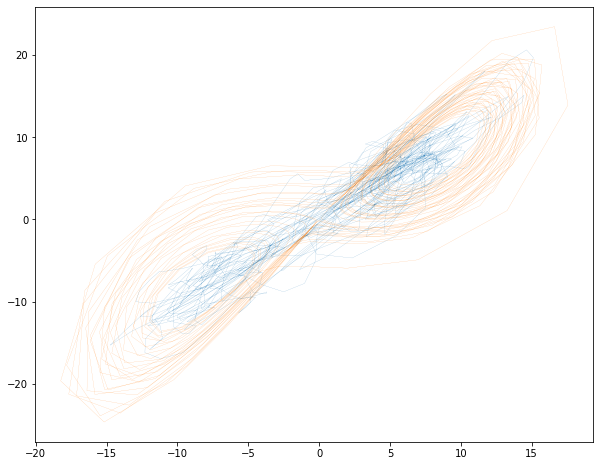

In [205]:
plt.figure(figsize=(10, 8))
plt.plot(y_test_pred[:, 0], y_test_pred[:, 1], linewidth=0.1)
plt.plot(y_test[:, 0], y_test[:, 1], linewidth=0.1)

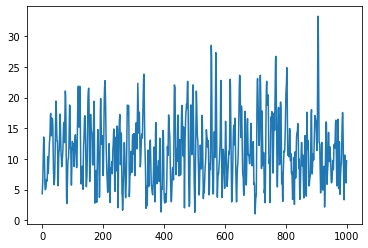

In [206]:
error = np.linalg.norm(y_test_pred - y_test, axis=1)
plt.plot(error)

# KS iterator:


In [ ]:
dims = 200
L = 100

def data_creation_function_ks(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("kuramoto_sivashinsky_custom", dt, time_steps, starting_point, fft_type="scipy", dimensions=dims, system_size=L)

dt_ks = 0.5
def f_ks(x):
    return data_creation_function_ks(2, dt_ks, x)[-1]

In [ ]:
# test KS iterator:
time_steps = 1000
results_ks = np.zeros((time_steps, dims))

# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))

results_ks[0, :] = starting_point
for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    results_ks[i, :] = f_ks(x_last)

plt.imshow(results_ks.T, aspect="auto")

## Coupling of both systems:


In [0]:
w_in_scale = 0.0001
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))

In [0]:
# test KS iterator:
time_steps = 2000

# ks
results_ks = np.zeros((time_steps, dims))
# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))
results_ks[0, :] = starting_point

# lorenz:
results = np.zeros((time_steps, 3))
results[0, :] = np.array([0, 1, 0])

for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    x_last_in = results[i-1, :]
    x_add = w_in.dot(x_last_in)
    # if i > 1000:
    #     x_add = 0
    results_ks[i, :] = f_ks(x_last + x_add)
    results[i, :] = f(x_last_in)
plt.imshow(results_ks.T, aspect="auto")

In [ ]:
plt.plot(results[:, 0], results[:, 1], linewidth=0.1)
